<a href="https://colab.research.google.com/github/quickgrid/Image-Compression-SIREN/blob/main/image_compression_2d_grid_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget "https://live.staticflickr.com/2890/9683448580_bf20d69dc9_b.jpg" -O "img1.jpg"

--2021-04-20 12:20:16--  https://live.staticflickr.com/2890/9683448580_bf20d69dc9_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 13.35.30.221, 2600:9000:20db:1000:0:5a51:64c9:c681, 2600:9000:20db:4000:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|13.35.30.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘img1.jpg’

img1.jpg                [ <=>                ] 205.63K  --.-KB/s    in 0.07s   

2021-04-20 12:20:16 (2.96 MB/s) - ‘img1.jpg’ saved [210569]



In [2]:
import os

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SineLayer(nn.Module):
    def __init__(self, input_units, output_units, bias=True, is_first=False, omega_0=30, weight_init_type='uniform'):
        """Implementation of sine layer.

        Calculates omega_0 * Wx + b as proposed in paper section 3.2 last paragraph.
        If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the nonlinearity.
        Different signals may require different omega_0 in the first layer - this is a hyperparameter.

        See below for more details,
        https://github.com/vsitzmann/siren
        https://arxiv.org/abs/2006.09661

        Args:
            input_units:
            output_units:
            bias:
            is_first:
            omega_0:
            weight_init_type:

        Returns:
            omega_0 * Wx + b followed by sine activation.

        Raises:
            Exception: Unsupported weight initialization type.
        """

        super(SineLayer, self).__init__()

        self.omega_0 = omega_0
        self.is_first = is_first
        self.input_units = input_units
        self.weight_init_type = weight_init_type

        self.linear = nn.Linear(in_features=input_units, out_features=output_units, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.weight_init_type == 'uniform':
                if self.is_first:
                    torch.nn.init.uniform_(self.linear.weight, -1 / self.input_units, 1 / self.input_units)
                else:
                    torch.nn.init.uniform_(self.linear.weight, -np.sqrt(6 / self.input_units) / self.omega_0, np.sqrt(6 / self.input_units) / self.omega_0)
            elif self.weight_init_type == 'normal':
                if self.is_first:
                    torch.nn.init.normal_(self.linear.weight, -1 / self.input_units, 1 / self.input_units)
                else:
                    torch.nn.init.normal_(self.linear.weight, -np.sqrt(6 / self.input_units) / self.omega_0, np.sqrt(6 / self.input_units) / self.omega_0)
            else:
                raise Exception(F'{self.weight_init_type} is not valid, only `uniform` or `normal` allowed.')

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


class SIREN(nn.Module):
    def __init__(self, input_units, hidden_units, hidden_layer_count, output_units, first_omega_0=30, hidden_omega_0=30, outermost_linear=True, weight_init_type='uniform'):
        """SIREN implementation width only linear layers.

        Args:
            input_units:
            hidden_units:
            hidden_layer_count:
            output_units:
            first_omega_0:
            hidden_omega_0:
            outermost_linear:
            weight_init_type:

        Returns:
            Predicted pixel color output and pixel coordinates.

        Raises:
            Exception: Unsupported weight initialization type.
        """
        super(SIREN, self).__init__()

        self.hidden_layer_count = hidden_layer_count
        self.input_layer = SineLayer(input_units=input_units, output_units=hidden_units, is_first=True, omega_0=first_omega_0, weight_init_type=weight_init_type)
        
        # self.hidden_layer = SineLayer(input_units=hidden_units, output_units=hidden_units, is_first=False, omega_0=hidden_omega_0)
        self.hidden_layers = nn.ModuleList([SineLayer(input_units=hidden_units, output_units=hidden_units, is_first=False, omega_0=hidden_omega_0) for i in range(hidden_layer_count)])

        if outermost_linear:
            self.output_layer = nn.Linear(in_features=hidden_units, out_features=output_units)

            with torch.no_grad():
                if weight_init_type == 'uniform':
                    torch.nn.init.uniform_(self.output_layer.weight, -np.sqrt(6 / hidden_units) / hidden_omega_0, np.sqrt(6 / hidden_units) / hidden_omega_0)
                elif weight_init_type == 'normal':
                    torch.nn.init.uniform_(self.output_layer.weight, -np.sqrt(6 / hidden_units) / hidden_omega_0, np.sqrt(6 / hidden_units) / hidden_omega_0)
                else:
                    raise Exception(F'{weight_init_type} is not supported. Try `uniform` or `normal`.')
        else:
            self.output_layer = SineLayer(input_units=hidden_units, output_units=output_units, is_first=False, omega_0=hidden_omega_0)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)

        x = self.input_layer(coords)
        
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)

        output = self.output_layer(x)

        return output, coords


In [4]:
def get_mesh_grid(image_height, image_width, image_channels=3):
    """Generates 2D and 3D mesh grid of image indices.

    Works with non square image shapes based on image height and width.
    For image channels set to 1 it generates values from -1 to 1 based on image (height, width).
    For image channels set to 3 it generates values from -1 to 1 based on image (height, width, channels).

    Args:
        image_height: Input image height
        image_width: Input image width
        image_channels: Input image channels. Only RGB or Greyscale allowed.

    Returns:
        2D or 3D mesh grid based on number of image_channels.

    Raises:
        Exception unsupported image channels.
    """

    if image_channels == 3:
        t1 = tuple([torch.linspace(-1, 1, steps=image_height)])
        t2 = tuple([torch.linspace(-1, 1, steps=image_width)])
        t3 = tuple([torch.linspace(-1, 1, steps=image_channels)])
        mesh_grid = torch.stack(torch.meshgrid(*t1, *t2, *t3), dim=-1)
        mesh_grid = mesh_grid.reshape(-1, image_channels)
        return mesh_grid
    elif image_channels == 1:
        t1 = tuple([torch.linspace(-1, 1, steps=image_height)])
        t2 = tuple([torch.linspace(-1, 1, steps=image_width)])
        mesh_grid = torch.stack(torch.meshgrid(*t1, *t2), dim=-1)
        mesh_grid = mesh_grid.reshape(-1, 2)
        return mesh_grid
    else:
      raise Exception(F'{image_channels} not allowed try 1 or 3.')


In [5]:
class ImagePixelCoordsDataset(Dataset):
    def __init__(self, image_path, image_height=None, image_width=None):
        """A single image dataset.

        Resizes image based on given height, width and converts to tensor.

        Args:
            image_path:
            image_height:
            image_width:

        Returns:
            Image coordinates and pixel values.

        Raises:
            IndexError if index more than zero.
        """

        super(ImagePixelCoordsDataset, self).__init__()
        self.image_path = image_path
        self.image_height = image_height
        self.image_width = image_width

        self.transform = transforms.Compose([
            transforms.Resize((self.image_height, self.image_width)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0:
            raise IndexError

        img = Image.open(self.image_path)

        if self.image_height is not None or self.image_width is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        im_c, im_h, im_w = img.shape
        coords = get_mesh_grid(im_h, im_w, 1)
        pixels = torch.reshape(img.permute(1, 2, 0), (-1, 3))

        return coords, pixels

In [6]:
image_path = '/content/img1.jpg'
save_path = '/content/siren_model.pt'

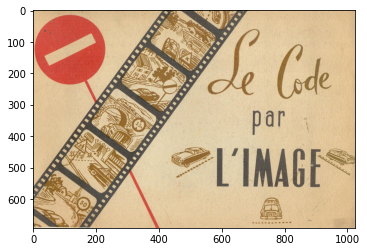

In [7]:
img = Image.open(image_path)
plt.imshow(img)
plt.show()

In [8]:
img_array = np.array(img)
im_height, im_width, im_channels = img_array.shape

 
im_width = im_width // 2
im_height = im_height // 2

print(im_height, im_width, im_channels)

346 512 3


In [18]:
#im_height, im_width, im_channels = (600, 830, 3)

image_dataset = ImagePixelCoordsDataset(image_path=image_path, image_height=im_height, image_width=im_width)

dataloader = DataLoader(image_dataset, batch_size=1, pin_memory=True, num_workers=0)
model_siren = SIREN(input_units=2, output_units=3, hidden_units=128, hidden_layer_count=2, outermost_linear=True).to(device)

optimizer = torch.optim.Adam(lr=1e-3, params=model_siren.parameters())

print(model_siren)

SIREN(
  (input_layer): SineLayer(
    (linear): Linear(in_features=2, out_features=128, bias=True)
  )
  (hidden_layers): ModuleList(
    (0): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)


In [19]:
total_steps = 1000
steps_till_summary = 50
prev_loss = 2 ** 8

In [20]:
total_params = np.sum(p.numel() for p in model_siren.parameters())
print(total_params)

33795


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 0, Total Loss 0.436246782541275


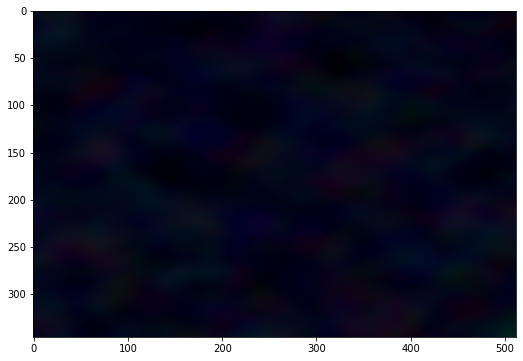

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 50, Total Loss 0.006483589764684439


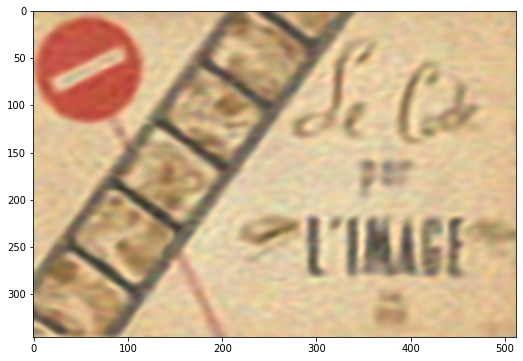

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 100, Total Loss 0.0046823900192976


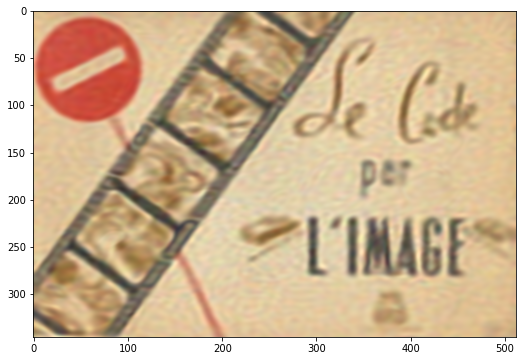

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 150, Total Loss 0.0036173490807414055


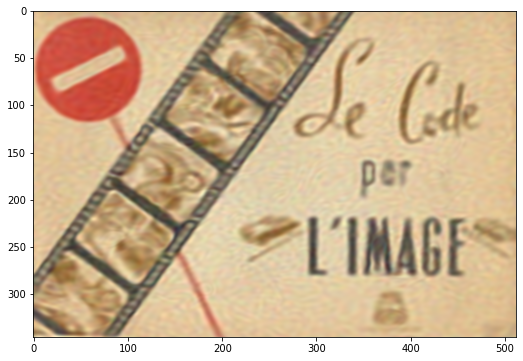

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 200, Total Loss 0.0029054933693259954


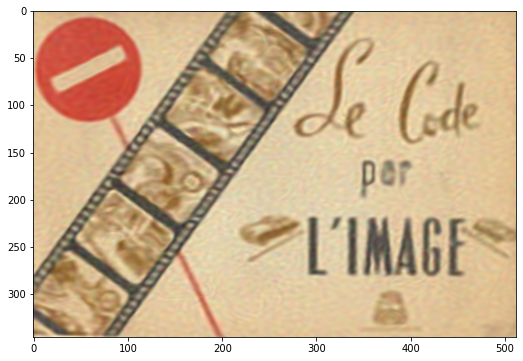

Step 250, Total Loss 0.0024798610247671604


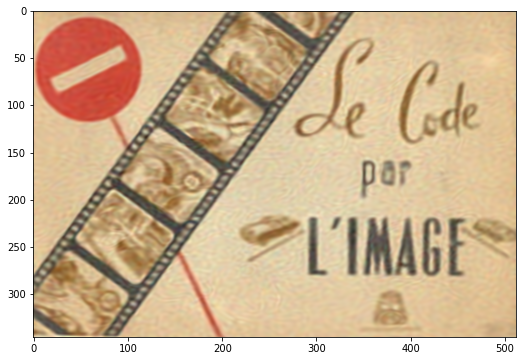

Step 300, Total Loss 0.002140218857675791


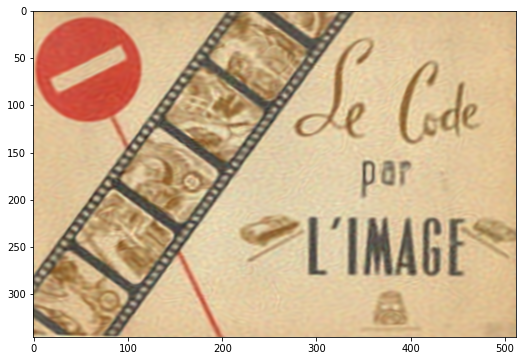

Step 350, Total Loss 0.0019411476096138358


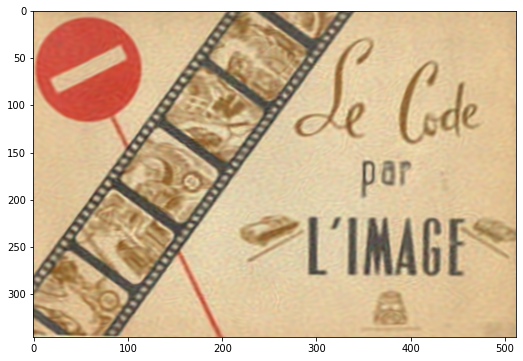

Step 400, Total Loss 0.0017873544711619616


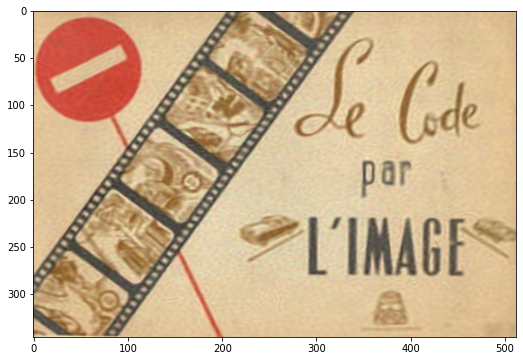

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 450, Total Loss 0.0016831570537760854


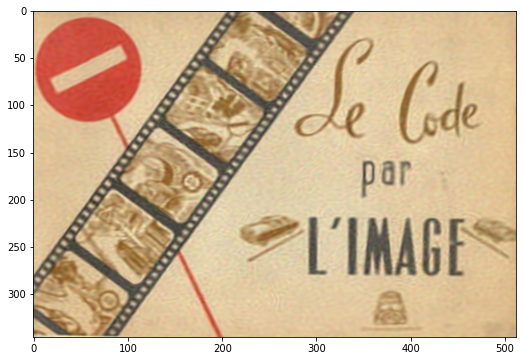

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 500, Total Loss 0.0016363599570468068


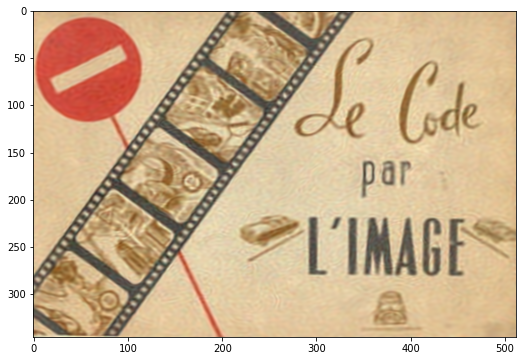

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 550, Total Loss 0.0015445305034518242


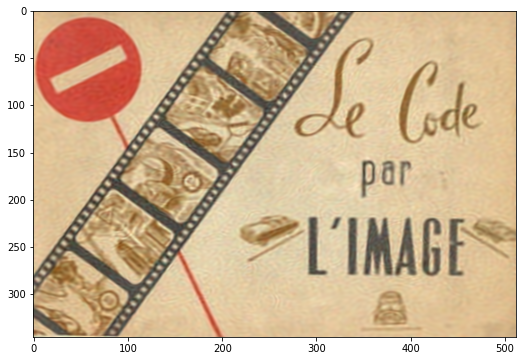

Step 600, Total Loss 0.0014838154893368483


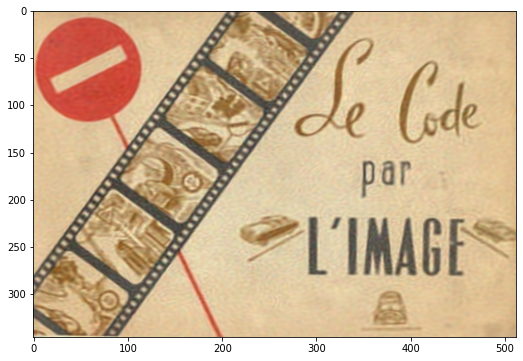

Step 650, Total Loss 0.0014283561613410711


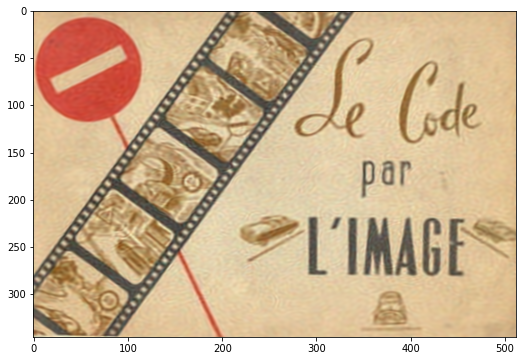

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 700, Total Loss 0.0014065844006836414


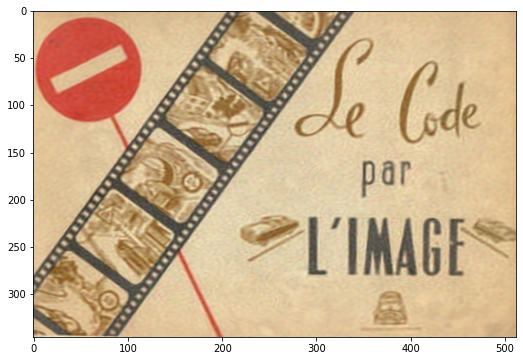

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 750, Total Loss 0.0013544118264690042


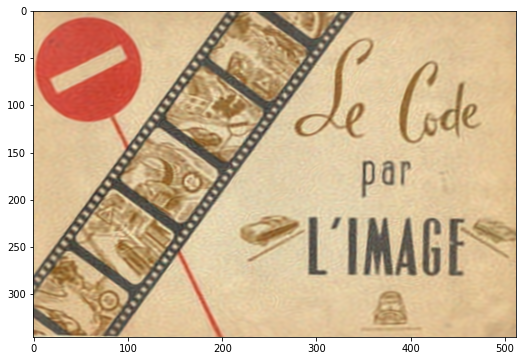

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 800, Total Loss 0.0013105949619784951


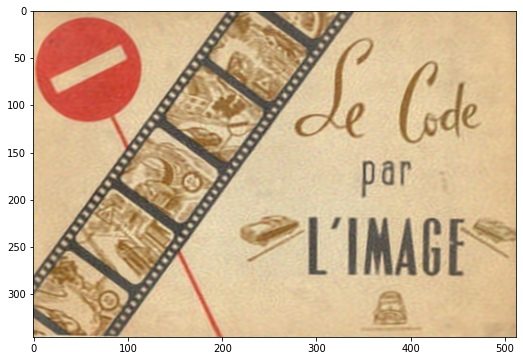

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 850, Total Loss 0.0013253566576167941


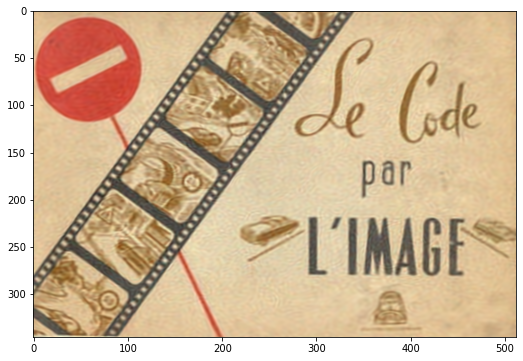

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 900, Total Loss 0.0012967984657734632


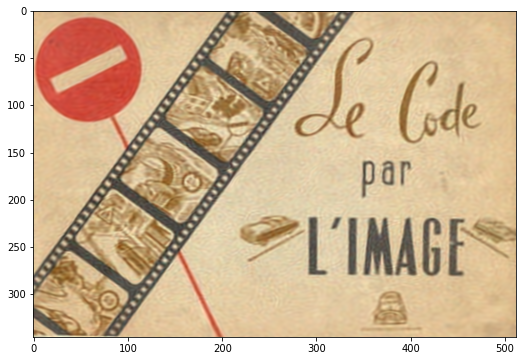

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 950, Total Loss 0.0012901445152238011


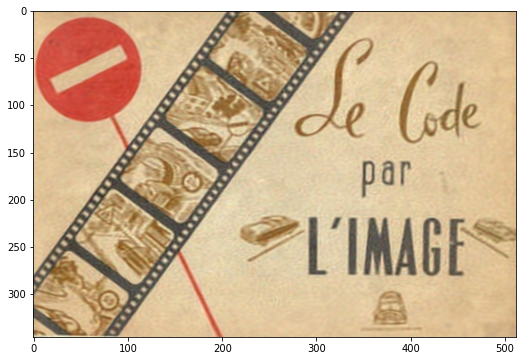

In [21]:
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

for step in range(total_steps):
    model_output, coords = model_siren(model_input)

    loss = ((model_output - ground_truth) ** 2).mean()

    if not step % steps_till_summary:
        print(F'Step {step}, Total Loss {loss}')

        fig, axs = plt.subplots(1, 1, figsize=(18, 6))
        axs.imshow(
            model_output.cpu().view(im_height, im_width, im_channels).detach().numpy()
        )
        plt.show()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        cur_loss = loss.cpu().detach().numpy()
        if(cur_loss < prev_loss):
            prev_loss = cur_loss
            torch.save(model_siren.state_dict(), save_path)


In [22]:
loaded_model = SIREN(input_units=2, output_units=3, hidden_units=128, hidden_layer_count=2, outermost_linear=True).to(device)
loaded_model.load_state_dict(torch.load('/content/siren_model.pt'))

<All keys matched successfully>

## Low resolution decoding

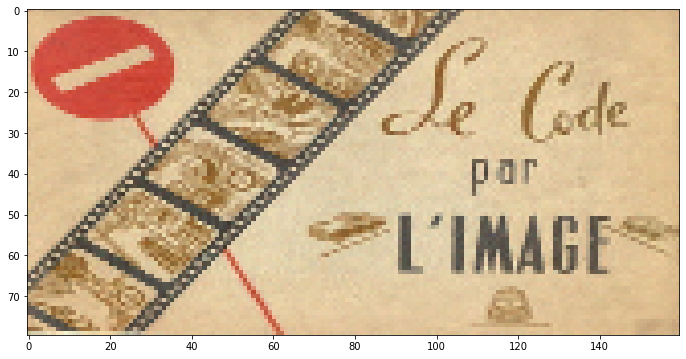

In [23]:
loaded_model.eval()
with torch.no_grad():

  c_h, c_w, c_c = (80, 160, 1)

  model_input1 = get_mesh_grid(c_h, c_w, c_c)
  model_input1 = model_input1.to(device)

  model_output1, coords1 = loaded_model(model_input1)

  output_image_numpy_array = model_output1.cpu().view(c_h, c_w, 3).detach().numpy()

  scaled_output_image_numpy_array = np.uint8((output_image_numpy_array - output_image_numpy_array.min()) / (output_image_numpy_array.max() - output_image_numpy_array.min()) * 255)

  #im2 = Image.fromarray(scaled_output_image_numpy_array)
  #im2.save('/content/img2.jpg')

  fig, axes = plt.subplots(1,1, figsize=(18,6))
  axes.imshow(output_image_numpy_array)
  plt.show()

## Decoding in trained resolution

torch.Size([1, 177152, 2]) torch.Size([1, 177152, 3])
tensor(0.0012, device='cuda:0')


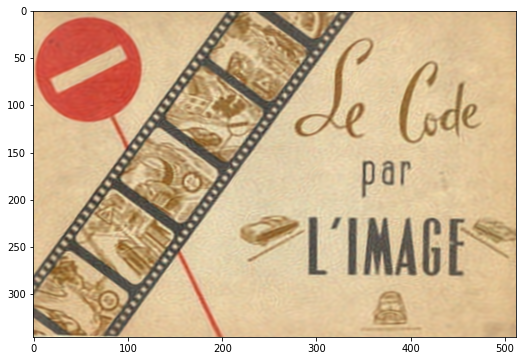

In [25]:
loaded_model.eval()
with torch.no_grad():

  model_input1, ground_truth1 = next(iter(dataloader))
  print(model_input1.shape, ground_truth1.shape)
  model_input1 = model_input1.cuda()
  ground_truth1 = ground_truth1.cuda()

  c_h, c_w, c_c = (346, 512, 1)

  model_output1, coords1 = loaded_model(model_input1)

  print(((model_output1 - ground_truth1)**2).mean())

  output_image_numpy_array = model_output1.cpu().view(c_h, c_w, 3).detach().numpy()

  scaled_output_image_numpy_array = np.uint8((output_image_numpy_array - output_image_numpy_array.min()) / (output_image_numpy_array.max() - output_image_numpy_array.min()) * 255)

  #im2 = Image.fromarray(scaled_output_image_numpy_array)
  #im2.save('/content/img2.jpg')

  fig, axes = plt.subplots(1,1, figsize=(18,6))
  axes.imshow(output_image_numpy_array)
  plt.show()